In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

d:\minorProject\WDSS\jupyter_notebooks
d:\minorProject\WDSS


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Time
import time

from typing import List, Tuple, Dict

from config import device , Settings

In [3]:
from utils.image_utils import ImageUtils
from utils.wavelet import WaveletProcessor

In [4]:
from network.dataset import WDSSDatasetCompressed

dataset = WDSSDatasetCompressed(Settings.dataset_path, 120, 128, 2)
testing_dataset = WDSSDatasetCompressed(Settings.dataset_path, 120, None, 2)

In [5]:
from network.modules.feature_extractors import LRFrameFeatureExtractor,HRGBufferFeatureExtractor
from network.modules.reconstruction_modules import FeatureFusion
from network.modules.fminr import FourierMappedINR

class WDSSV4(nn.Module):
    def __init__(self):
        super(WDSSV4, self).__init__()

        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 64, [32, 48, 48])
        self.hrg_buffer_feature_extractor = HRGBufferFeatureExtractor(48, 64, [64, 64, 64, 64, 64])
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])
        self.inr = FourierMappedINR(lr_feat_c=32, gb_feat_c=32, out_channels=12, mlp_inp_channels=64, hidden_channels=[64, 64, 64])
        
        # Final Convolution layers
        # Four sets of 3x3 cov layers, to process the different wavelet levels
        self.final_conv = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 3, kernel_size=3, padding=1)
            )
            for _ in range(4)
        ])

    def forward(self, lr_frame: torch.Tensor, hr_gbuffer: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffer, 2)

        lr_frame_feature = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        hr_gbuffer_feature = self.hrg_buffer_feature_extractor(hr_gbuffers_pixel_unshuffled)

        # Split the lr_frame_feature and hr_gbuffer_feature into 2-2 parts
        lr_frame_ff, lr_frame_inr = torch.split(lr_frame_feature, 32, dim=1)
        hr_gbuffer_ff, hr_gbuffer_inr = torch.split(hr_gbuffer_feature, 32, dim=1)

        # Upsample the lr_frame_ff
        lr_frame_ff = ImageUtils.upsample(lr_frame_ff, 2)

        # Feature Fusion, input is concatenated lr_frame_ff and hr_gbuffer_ff
        feature_fusion = self.feature_fusion(torch.cat([lr_frame_ff, hr_gbuffer_ff], dim=1))

        # INR
        inr = self.inr(lr_frame_inr, hr_gbuffer_inr)

        # Element-wise addition
        wavelet_output = feature_fusion + inr

        # Go through the final conv layers
        wavelet_output = torch.cat([self.final_conv[i](wavelet_output[:, i*3:i*3+3, :, :]) for i in range(len(self.final_conv))], dim=1)

        return wavelet_output, WaveletProcessor.batch_iwt(wavelet_output)

In [6]:
# Model
model = WDSSV4().to(device)
test  = dataset[0]
lr_frame = test['LR'].unsqueeze(0).to(device)
hr_gbuffer = test['GB'].unsqueeze(0).to(device)
print(lr_frame.shape, hr_gbuffer.shape)

torch.Size([1, 3, 128, 128]) torch.Size([1, 12, 256, 256])


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


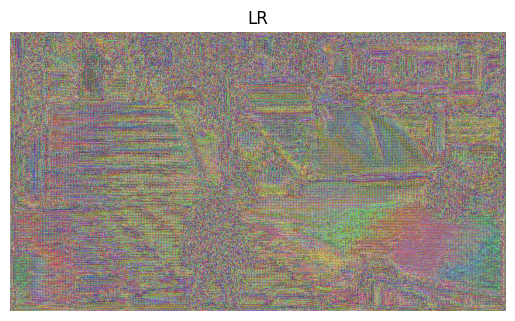

In [7]:
# Test an image
model.eval()
with torch.no_grad():
    lr_frame = testing_dataset[0]['LR'].unsqueeze(0).to(device)
    hr_gbuffer = testing_dataset[0]['GB'].unsqueeze(0).to(device)
    _, image = model(lr_frame, hr_gbuffer)
    ImageUtils.display_image(image[0].cpu(), "LR")

In [8]:
# Variables and train utils

from network.losses import WaveletCriterion, ImageEvaluator
import threading

# Criterion
criterion = WaveletCriterion().to(device)
# Optimizer
lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# Data Loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
epoch_loss: float = 0.0

losses_per_epochs: Dict[int, float] = {}

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\weights\v0.1\vgg.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_locatio

Loading model from: c:\Users\kunwa\Anaconda\envs\wdss\Lib\site-packages\lpips\weights\v0.1\vgg.pth


In [9]:
total_epochs = 11

In [10]:
# Training loop

epochs: int = 100

def do_nothing():
    return

def train(i, batch):
    global epoch_loss
    lr_frames = batch['LR'].to(device)
    hr_gbuffers = batch['GB'].to(device)
    hr_images = batch['HR'].to(device)
    hr_images_wavelet = WaveletProcessor.batch_wt(hr_images)
    
    optimizer.zero_grad()

    wavelet_out, image_out = model.forward(lr_frames, hr_gbuffers)
    loss, losses = criterion.forward(wavelet_out, hr_images_wavelet, image_out, hr_images)
    # print(loss)
    # print(losses)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    print(f"Batch {i} Loss: {loss.item()}")

threadu = threading.Thread(target=do_nothing)
threadu.start()

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0.0

    for i, batch in enumerate(data_loader):
        if (epoch == 0):
            break

        if (threadu.is_alive()):
            threadu.join()

        threadu = threading.Thread(target=train, args=(i, batch))
        threadu.start()
    
    if (threadu.is_alive()):
        threadu.join()
    print(f"Epoch {epoch} Loss: {epoch_loss}")
    # Save the model to model/v4/epoch_{epoch}_time_{time.time()}.pth
    torch.save(model.state_dict(), f"model/v4/epoch_{total_epochs}_time_{time.time()}.pth")
    losses_per_epochs[total_epochs] = epoch_loss

    # Store the losses per epoch to a file
    with open('model/v4.txt', 'w') as f:
        f.write(str(losses_per_epochs))

    total_epochs += 1

    if (epoch % 20) == 0:
        lr = lr / 2.0
        optimizer = optim.Adam(model.parameters(), lr=lr)



Epoch 0 Loss: 0.0
Batch 0 Loss: 0.5712243318557739
Batch 1 Loss: 0.5755879282951355
Batch 2 Loss: 0.5662718415260315
Batch 3 Loss: 0.5624879598617554
Batch 4 Loss: 0.5714603662490845
Batch 5 Loss: 0.5651664733886719
Batch 6 Loss: 0.5683261156082153
Batch 7 Loss: 0.5632593035697937
Batch 8 Loss: 0.5666671395301819
Batch 9 Loss: 0.5476792454719543
Batch 10 Loss: 0.5410343408584595
Batch 11 Loss: 0.537697970867157
Batch 12 Loss: 0.5289985537528992
Batch 13 Loss: 0.5233345627784729
Batch 14 Loss: 0.5174893140792847
Epoch 1 Loss: 8.306685447692871
Batch 0 Loss: 0.5093890428543091
Batch 1 Loss: 0.506538987159729
Batch 2 Loss: 0.5164428353309631
Batch 3 Loss: 0.5120733976364136
Batch 4 Loss: 0.510499119758606
Batch 5 Loss: 0.4906199872493744
Batch 6 Loss: 0.48779696226119995
Batch 7 Loss: 0.49245911836624146
Batch 8 Loss: 0.4870612323284149
Batch 9 Loss: 0.4878564178943634
Batch 10 Loss: 0.4802910089492798
Batch 11 Loss: 0.4868786931037903
Batch 12 Loss: 0.47212421894073486
Batch 13 Loss: 0.4

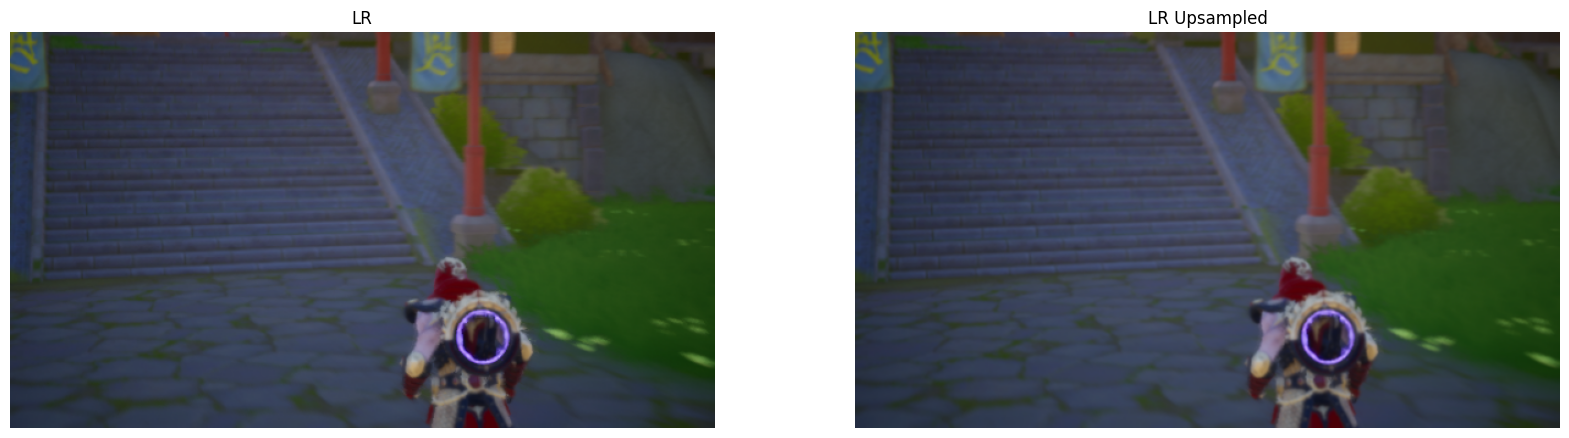

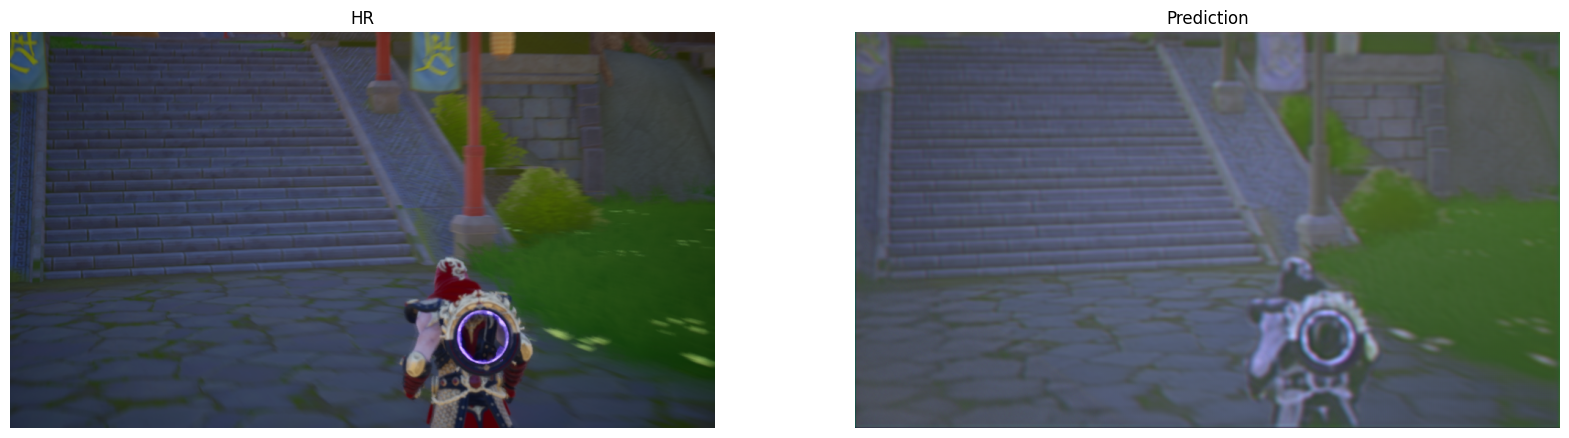

MSE Prediction: 0.0015349941095337272, Upsampled: 0.0003483629261609167
PSNR Prediction: 28.138933181762695, Upsampled: 34.579681396484375
SSIM Prediction: 0.9030641317367554, Upsampled: 0.9463401436805725
LPIPS Prediction: 0.2711487412452698, Upsampled: 0.18909499049186707


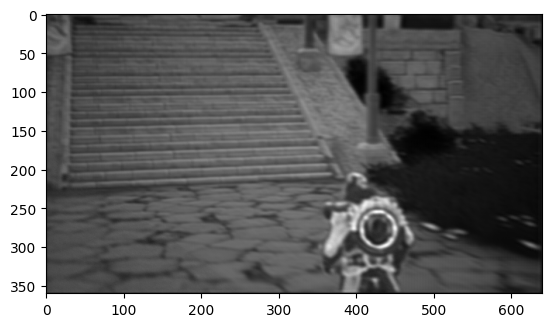

In [11]:
def test_image(data_no: int):
    model.eval()
    with torch.no_grad():
        lr_frame = testing_dataset[data_no]['LR'].unsqueeze(0).to(device)
        hr_gbuffer = testing_dataset[data_no]['GB'].unsqueeze(0).to(device)
        hr_image = testing_dataset[data_no]['HR'].unsqueeze(0).to(device)
        wavelets, image = model(lr_frame, hr_gbuffer)
    
    # Perform bilinear upscaling
    lr_frame_upsampled = ImageUtils.upsample(lr_frame, 2)

    # Display the images
    ImageUtils.display_images([lr_frame.cpu(), lr_frame_upsampled.cpu()], ["LR", "LR Upsampled"])
    ImageUtils.display_images([hr_image.cpu(), image.cpu()], ["HR", "Prediction"])
    
    approx_r = wavelets[0, 2:3, :, :].detach().cpu().numpy()
    # Plot the approx_r
    plt.imshow(approx_r[0], cmap='gray')

    # Compute the losses
    pred_mse = ImageEvaluator.mse(image, hr_image)
    upsampled_mse = ImageEvaluator.mse(lr_frame_upsampled, hr_image)
    print(f"MSE Prediction: {pred_mse}, Upsampled: {upsampled_mse}")

    pred_psnr = ImageEvaluator.psnr(image, hr_image)
    upsampled_psnr = ImageEvaluator.psnr(lr_frame_upsampled, hr_image)
    print(f"PSNR Prediction: {pred_psnr}, Upsampled: {upsampled_psnr}")

    pred_ssim = ImageEvaluator.ssim(image, hr_image)
    upsampled_ssim = ImageEvaluator.ssim(lr_frame_upsampled, hr_image)
    print(f"SSIM Prediction: {pred_ssim}, Upsampled: {upsampled_ssim}")

    pred_lpips = ImageEvaluator.lpips(image, hr_image).item()
    upsampled_lpips = ImageEvaluator.lpips(lr_frame_upsampled, hr_image).item()
    print(f"LPIPS Prediction: {pred_lpips}, Upsampled: {upsampled_lpips}")

test_image(60)

    

In [15]:
# Save Model to model/v4.1.pth
torch.save(model.state_dict(), "model/v4.1.pth")